We spotted that the strings in the first column could be split into usefull data. We transformed that data to at% using the formula under : 



$\text{at\% of element} = \frac{\sum_{i=1}^{n} (n_i \times M_i)}{n_{\text{element}} \times M_{\text{element}}} \times 100$




In [3]:
#Import all libraries necessary for the code

import pandas as pd
import numpy as np
import random
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier

In [4]:
# Define the molar fractions and atomic weights of each element in the composition

def parse_composition_string(composition_string : str) -> pd.DataFrame: 
    """
    This function takes a composition string as input and returns
    a DataFrame with the weight percentages of each element in the composition.
    """
    elements = []
    values = []
    temp = ''
    i = 0
    while i < len(composition_string):
        if composition_string[i].isalpha():
            if i + 1 < len(composition_string) and composition_string[i + 1].islower():
                elements.append(composition_string[i:i + 2].lower())
                i += 2
            else:
                elements.append(composition_string[i].lower())
                i += 1
            if temp:
                values.append(temp)
                temp = ''
        else:
            temp += composition_string[i]
            i += 1
    if temp:
        values.append(temp)

    molar_fractions = {elements[i]: float(values[i]) for i in range(len(elements))}

    # Atomic weights (g/mol)
    atomic_weights = {
        'fe': 55.845,
        'c': 12.011,
        'mn': 54.938,
        'si': 28.085,
        'cr': 51.996,
        'ni': 58.693,
        'mo': 95.95,
        'v': 50.942,
        'n': 14.007,
        'nb': 92.906,
        'co': 58.933,
        'w': 183.84,
        'al': 26.982,
        'ti': 47.867
    }

    # Calculate the molar mass of the mixture
    total_molar_mass = sum(molar_fractions[element] * atomic_weights[element] for element in molar_fractions)

    # Calculate weight percentage for each element
    weight_percentages = {
        element: (molar_fractions[element] * atomic_weights[element] / total_molar_mass) * 100
        for element in molar_fractions
    }

    # Create a DataFrame with the composition string and weight percentages
    data = {'Composition String': [composition_string]}
    data.update({element: [weight_percentages[element]] for element in weight_percentages})
    df_weight_percentages = pd.DataFrame(data)
    # # drop the column "Fe"
    # df_weight_percentages = df_weight_percentages.drop(columns=['fe'])

    return df_weight_percentages


we merged the data found above and the original data by overlaying them :

In [5]:
df = pd.read_csv('database_steel_properties (1).csv')
all_weight_percentages = pd.DataFrame()

# Iterate through each composition string in the DataFrame
for string in df['formula']:
    df_weight_percentages = parse_composition_string(string)
    all_weight_percentages = pd.concat([all_weight_percentages, df_weight_percentages], ignore_index=True)

# rearrange the columns as follow : Composition String, c,	mn	,si	,cr	,ni	,mo	,v	,n	,nb	,co	,w	,al	,ti
all_weight_percentages = all_weight_percentages[['Composition String', 'fe','c', 'mn', 'si', 'cr', 'ni', 'mo', 'v', 'n', 'nb', 'co', 'w', 'al', 'ti']]
all_weight_percentages = all_weight_percentages.rename(columns={'Composition String': 'formula'})
all_weight_percentages.to_excel('weight_percentages.xlsx', index=False)

# Merge the dataframes on 'formula' while prioritizing original file
df2 = pd.read_excel('weight_percentages.xlsx')
df3 = df.merge(df2, on='formula', how='left', suffixes=('', '_new'))

# Fill in missing values in the original dataframe with corresponding values from df2
for col in df3.columns:
    if col.endswith('_new'):  # Handle columns from the new file
        original_col = col.replace('_new', '')
        if original_col in df3.columns:  # Fill original column if it exists
            df3[original_col] = df3[original_col].fillna(df3[col])
        else:  # If no matching original column, rename the new column
            df3.rename(columns={col: original_col}, inplace=True)

# Drop '_new' columns if not needed
df3 = df3[[col for col in df3.columns if not col.endswith('_new')]]

df3 = df3[['formula', 'fe','c', 'mn', 'si', 'cr', 'ni', 'mo', 'v', 'n', 'nb', 'co', 'w', 'al', 'ti']]


# Save the result to a new Excel file
df3.to_excel('merged_file.xlsx', index=False)


We add back the mechanical properties to the file and we have spotted that the row 263 had a NaN value for 'w' we thus remove it. 


In [6]:
df4 = pd.read_excel('merged_file.xlsx')
df5 = pd.read_csv('database_steel_properties (1).csv')
mech_properties = ['yield strength', 'tensile strength', 'elongation']

# Merge the dataframes on formula
df_merged = pd.merge(df4, df5[['formula'] + mech_properties], on='formula', how='left')
df4_selected = df_merged[['formula', 'fe', 'c', 'mn', 'si', 'cr', 'ni', 'mo', 'v', 'n', 'nb', 'co', 'w', 'al', 'ti'] + mech_properties]

# remove line with that formula : "Fe0.788Mn0.000104Si0.000203Cr0.000109Ni0.176Mo0.0184V0.000112Nb0.0000613Co0.0000966Al0.00105Ti0.0166"
df4_selected = df4_selected[df4_selected['formula'] != 'Fe0.788Mn0.000104Si0.000203Cr0.000109Ni0.176Mo0.0184V0.000112Nb0.0000613Co0.0000966Al0.00105Ti0.0166']
# Save the result to merged_file.xlsx
df4_selected.to_excel('merged_file.xlsx', index=False)


We used Z-scoring standardization to transform the data, ensuring it has a mean of 0 and a standard deviation of 1. This step is crucial for models that rely on distance metrics, like KNN and Random Forest, as it ensures all features are treated equally regardless of their original scale. This prevents features with larger scales from dominating the results. Note that we manually added the mechanical properties of the samples in Excel.

In [7]:
data = pd.read_excel("merged_file.xlsx").copy()
inputs = data[['fe', 'c', 'mn', 'si', 'cr', 'ni', 'mo', 'v', 'n', 'nb', 'co', 'w', 'al', 'ti']]
scaler = StandardScaler()
normalized_inputs = scaler.fit_transform(inputs)
data[['fe', 'c', 'mn', 'si', 'cr', 'ni', 'mo', 'v', 'n', 'nb', 'co', 'w', 'al', 'ti']] = normalized_inputs
data.to_excel('normalized_file_complete.xlsx', index=False)

So the data is now normalized but we still miss the values for the mechanical properties.  
The first idea was to fill the blanks using basic methods such as means or median values. But as we had some time in front of us we decided to predict the values using the preprocessed data and the following methods:  
- Euclidean distance:  
    $ \text{Euclidean distance} = \sqrt{\sum_{i=1}^{n} (x_i)^2} $  
- K-nearest neighbor.
This step was made with the use of AI, but a deep understanding of knn was made using lecture notes and the following website : https://arize.com/blog-course/knn-algorithm-k-nearest-neighbor/#:~:text=KNN%20works%20in%20three%20main,value%20of%20the%20neighbors%2C%20respectively.

Explanation of why we did this instead of choosing mean/median imputation : we thougt that mean/median was less performant than doing what's under as we are doing a weighted mean/median but of the 5 similar looking composition than the one we are looking to fill , thus we target a more precise value of the mechanical properties by doing so. 

In [8]:
# Here we dont consider 
comp_columns = ['fe','c','mn', 'si', 'cr', 'ni', 'mo', 'v', 'n', 'nb', 'co', 'w', 'al', 'ti']
mech_properties = ['yield strength', 'tensile strength', 'elongation']

data =pd.read_excel( 'normalized_file_complete.xlsx')

# Function to impute missing values using k-nearest neighbors
def impute_with_knn(df: pd.DataFrame, k: int = 5) -> pd.DataFrame:
    """
    Impute missing values in a DataFrame using k-nearest neighbors.
    """
    imputed_df = df.copy()
    comp_data = df[comp_columns]
    mech_data = df[mech_properties]
    distances = euclidean_distances(comp_data)
    
    # Find rows with missing values for this property
    for prop in mech_properties:
        missing_mask = mech_data[prop].isna()
        
        if missing_mask.any():
            for idx in mech_data[missing_mask].index:
                # Find k nearest neighbors
                distances_to_current = distances[idx].copy()
                distances_to_current[idx] = np.inf  # Exclude self
                k_nearest_indices = np.argsort(distances_to_current)[:k]
                
                # Get the values of the property for these neighbors
                neighbor_values = mech_data.loc[k_nearest_indices, prop]
                neighbor_values = neighbor_values[~neighbor_values.isna()]
                
                # Impute with weighted average (closer neighbors have higher weight)
                if len(neighbor_values) > 0:
                    weights = 1 / distances_to_current[k_nearest_indices[:len(neighbor_values)]]
                    weights = weights / weights.sum()
                    imputed_value = np.average(neighbor_values, weights=weights)
                    imputed_df.loc[idx, prop] = imputed_value
    
    return imputed_df

# Perform imputation we choose k=5 here but it can be changed
imputed_data = impute_with_knn(data, k=5)

# Print summary of imputation
print("Original missing values:")
print(data[mech_properties].isna().sum())
print("\nImputed missing values:")
print(imputed_data[mech_properties].isna().sum())

imputed_data.to_excel('imputed_materials_data.xlsx', index=False)



Original missing values:
yield strength       4
tensile strength     5
elongation          13
dtype: int64

Imputed missing values:
yield strength      0
tensile strength    0
elongation          6
dtype: int64


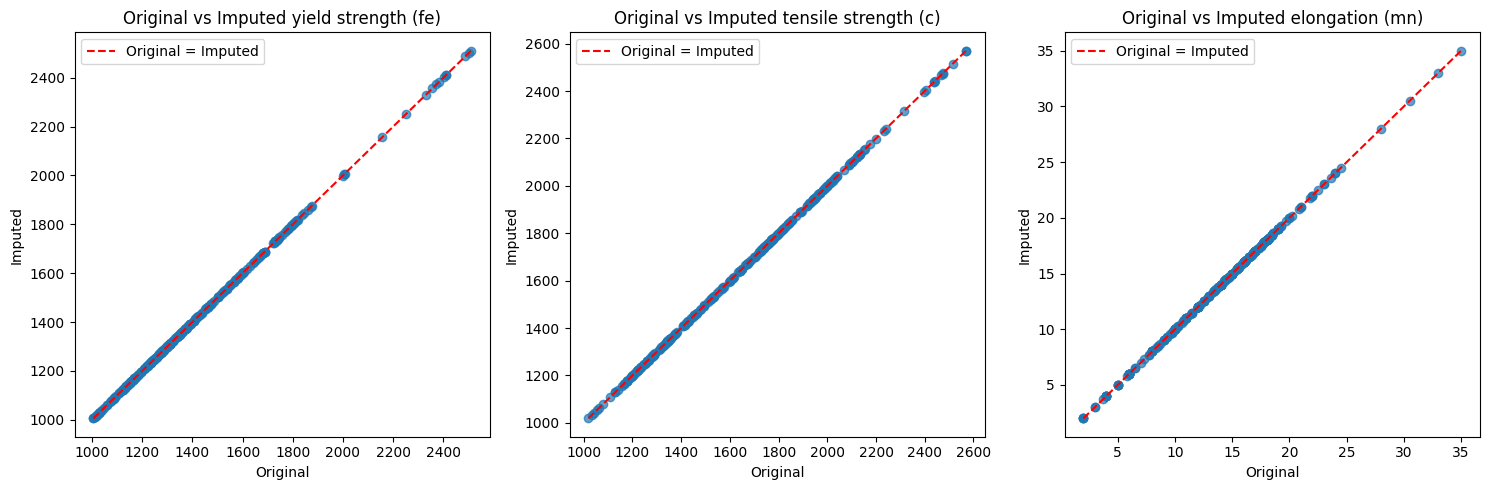


Imputation Validation:

yield strength:
Original Mean: 1415.63
Imputed Mean: 1420.20
Original Std Dev: 297.93
Imputed Std Dev: 302.12

tensile strength:
Original Mean: 1640.90
Imputed Mean: 1642.72
Original Std Dev: 346.91
Imputed Std Dev: 346.21

elongation:
Original Mean: 14.04
Imputed Mean: 14.07
Original Std Dev: 5.10
Imputed Std Dev: 5.07


In [9]:
# Visualization of imputation results
plt.figure(figsize=(15, 5))
for i, prop in enumerate(mech_properties):
    plt.subplot(1, 3, i+1)
    plt.scatter(data[prop], imputed_data[prop], alpha=0.7)
    plt.plot([data[prop].min(), data[prop].max()], 
             [data[prop].min(), data[prop].max()], 
             'r--', label='Original = Imputed')
    plt.title(f'Original vs Imputed {prop} ({comp_columns[i]})')
    plt.xlabel('Original')
    plt.ylabel('Imputed')
    plt.legend()

plt.tight_layout()
plt.show()

# Additional validation
def validate_imputation(original: pd.DataFrame, imputed: pd.DataFrame):
    print("\nImputation Validation:")
    for prop in mech_properties:
        original_mean = original[prop].mean()
        imputed_mean = imputed[prop].mean()
        original_std = original[prop].std()
        imputed_std = imputed[prop].std()
        
        print(f"\n{prop}:")
        print(f"Original Mean: {original_mean:.2f}")
        print(f"Imputed Mean: {imputed_mean:.2f}")
        print(f"Original Std Dev: {original_std:.2f}")
        print(f"Imputed Std Dev: {imputed_std:.2f}")

validate_imputation(data, imputed_data)

Then we labelled the values as fragile, medium, solid. As it did not make any sense to use one hot encoder nor frequency encoding. 

In [10]:
data = pd.read_excel("imputed_materials_data.xlsx").copy()

#function to classify elongation into categories: fragile, medium and strong
def classify_strength(elongation):
    if elongation < 5:
        return "Fragile"
    elif 5 <= elongation <= 10:
        return "Medium"
    elif elongation > 10 :
        return "Strong"
    else:
        return "Unknown"

data['strength_rating'] = data['elongation'].apply(classify_strength)

#This is the final data that will be used for the analysis
output_file = "final_steel_data.xlsx"
data.to_excel(output_file, index=False)


In [11]:
#Load the data saved

path_vlad = r"C:\Users\vladimir jurien\OneDrive - Imperial College London\Imperial\Y2\Steel Challenge\Challenge-2024-2025\final_steel_data.xlsx"
path_damaso = '/Users/damasomatheus/Desktop/Damaso\'s Stuff/Imperial/Materials/Year 2/MATE50001/coding challenge 24/Challenge-2024-2025/final_steel_data.xlsx'
who = input('Who are you? ')
if who == 'vlad':
    path = path_vlad
    
else:
    path = path_damaso
data = pd.read_excel(path)

Once the data was preprocessed we were ready to test out the different regression algorithms. We tested:

- Random Forest
- Ridge
- Lasso
- Linear
- Decision Tree

Using R^2 and MSE as metrics



--- Training models for Tensile Strength ---
Linear Regression: R² = 0.3936, MSE = 61285.47
Ridge Regression: R² = 0.4176, MSE = 58865.09
Lasso Regression: R² = 0.4542, MSE = 55161.82
Random Forest Regression: R² = 0.9135, MSE = 8737.84
Decision Tree Regression: R² = 0.8653, MSE = 13613.93

--- Training models for Yield Strength ---
Linear Regression: R² = -0.2029, MSE = 83146.14
Ridge Regression: R² = -0.1531, MSE = 79701.49
Lasso Regression: R² = -0.1059, MSE = 76444.58
Random Forest Regression: R² = 0.8282, MSE = 11872.71
Decision Tree Regression: R² = 0.7262, MSE = 18928.64


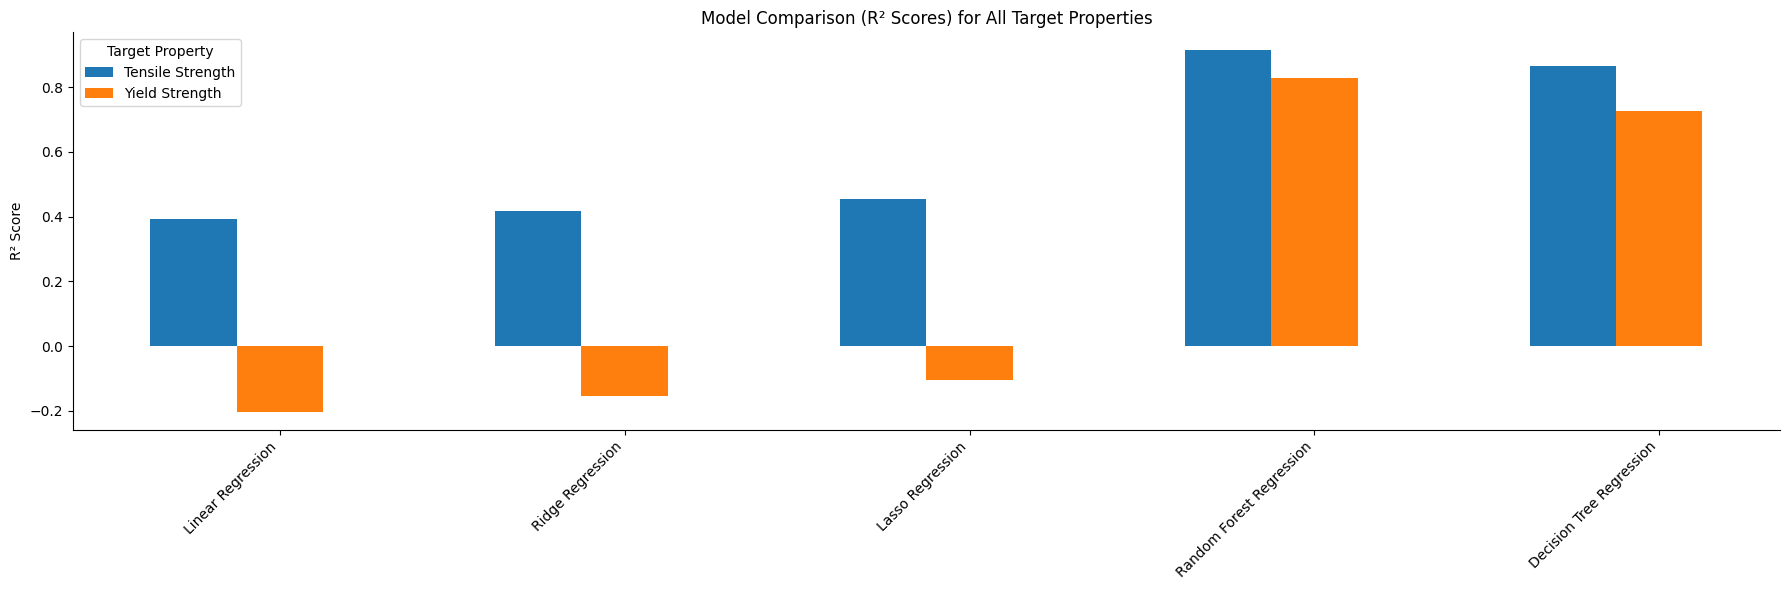

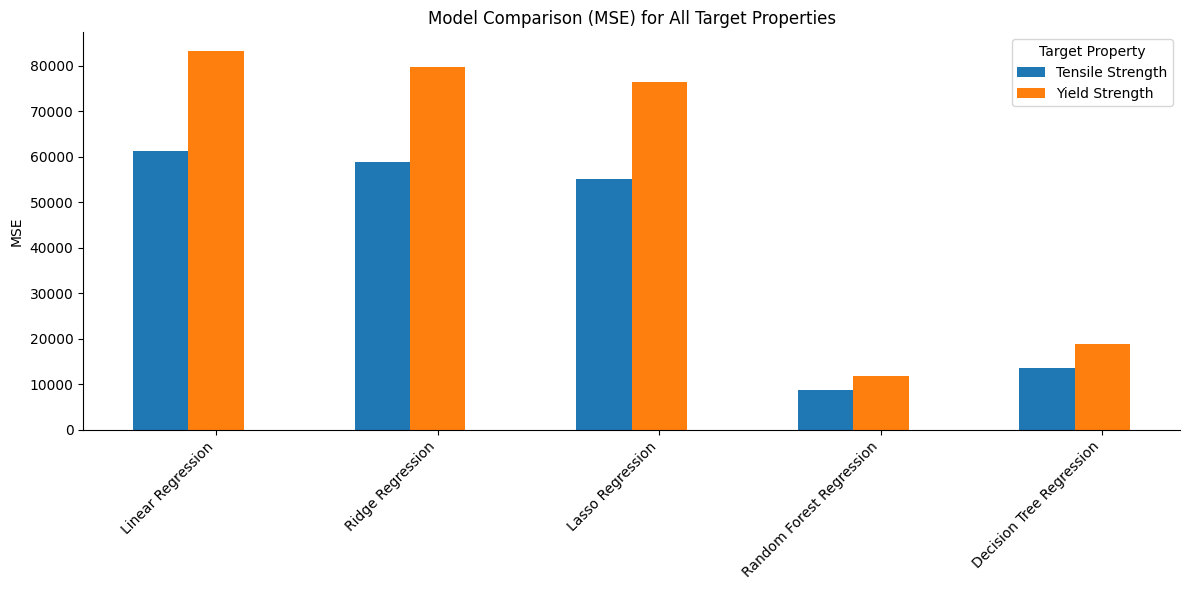


--- Training models for Tensile Strength ---
Linear Regression: R² = 0.3936, MSE = 61285.47
Ridge Regression: R² = 0.4176, MSE = 58865.09
Lasso Regression: R² = 0.4542, MSE = 55161.82
Random Forest Regression: R² = 0.9135, MSE = 8737.84
Decision Tree Regression: R² = 0.8653, MSE = 13613.93

--- Training models for Yield Strength ---
Linear Regression: R² = -0.2029, MSE = 83146.14
Ridge Regression: R² = -0.1531, MSE = 79701.49
Lasso Regression: R² = -0.1059, MSE = 76444.58
Random Forest Regression: R² = 0.8282, MSE = 11872.71
Decision Tree Regression: R² = 0.7262, MSE = 18928.64

Best models saved for each target property!


In [12]:
#Inputs (standardized compositions)
X = data[['fe', 'c', 'mn', 'si', 'cr', 'ni', 'mo', 'v', 'n', 'nb', 'co', 'w', 'al', 'ti']]

#Outputs (mechanical properties)
targets = {
    "Tensile Strength": data['tensile strength'],
    "Yield Strength": data['yield strength']
}

#Define regression models so that the experiment can be re-run
RANDOM_STATE = 42
TEST_SIZE = 0.2
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "Random Forest Regression": RandomForestRegressor(n_estimators=100, random_state=RANDOM_STATE),
    "Decision Tree Regression": DecisionTreeRegressor(random_state=RANDOM_STATE),
}

#Initialize dictionary to store R² results
r2_results = {target_name: {} for target_name in targets.keys()}

#Train models and gather results
for target_name, y in targets.items():
    print(f"\n--- Training models for {target_name} ---")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)
    
    for model_name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        r2 = r2_score(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        r2_results[target_name][model_name] = r2  # Store R² score
        
        print(f"{model_name}: R² = {r2:.4f}, MSE = {mse:.2f}")

#Plot R² scores for all targets and models
fig, ax1 = plt.subplots(figsize=(18, 6))
x = np.arange(len(models))  
bar_width = 0.25
for i, (target_name, r2_scores) in enumerate(r2_results.items()):
    r2_values = list(r2_scores.values())
    ax1.bar(x + i * bar_width, r2_values, bar_width, label=target_name)
ax1.set_xticks(x + bar_width)
ax1.set_xticklabels(models.keys(), rotation=45, ha='right')
ax1.set_ylabel("R² Score")
ax1.set_title("Model Comparison (R² Scores) for All Target Properties")
ax1.legend(title="Target Property")
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
plt.tight_layout()

# Initialize dictionary to store MSE results
mse_results = {target_name: {} for target_name in targets.keys()}

# Train models and gather MSE results
for target_name, y in targets.items():
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)
    
    for model_name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        mse_results[target_name][model_name] = mse  # Store MSE score

# Plot MSE scores for all targets and models
fig, ax2 = plt.subplots(figsize=(12, 6))
for i, (target_name, mse_scores) in enumerate(mse_results.items()):
    mse_values = list(mse_scores.values())
    ax2.bar(x + i * bar_width, mse_values, bar_width, label=target_name)
ax2.set_xticks(x + bar_width)
ax2.set_xticklabels(models.keys(), rotation=45, ha='right')
ax2.set_ylabel("MSE")
ax2.set_title("Model Comparison (MSE) for All Target Properties")
ax2.legend(title="Target Property")
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

# display everything
plt.tight_layout()
plt.show()

# Train and Save Best Models
best_models = {}
for target_name, y in targets.items():
    print(f"\n--- Training models for {target_name} ---")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)
    
    best_model = None
    best_r2 = float("-inf")
    for model_name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        r2 = r2_score(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        print(f"{model_name}: R² = {r2:.4f}, MSE = {mse:.2f}")
        if r2 > best_r2:
            best_r2 = r2
            best_model = model

    # Save the best model to a file
    joblib.dump(best_model, f"{target_name.replace(' ', '_').lower()}_regressor.pkl")
    best_models[target_name] = best_model

print("\nBest models saved for each target property!")


Now that the regression algorithms have been trained, we needed to classify the data. We chose k-Nearest Neighbors (kNN), Random Forest, and Logistic Regression for this task. These methods leverage the relationships between features to classify the strength rating of the materials. By using these classifiers, we ensure that the predictions are based on the underlying patterns in the data, leading to more accurate and meaningful classifications compared to simpler methods.


--- k-Nearest Neighbors ---
Accuracy: 0.8710
Classification Report:
              precision    recall  f1-score   support

     Fragile       0.00      0.00      0.00         3
      Medium       0.78      0.64      0.70        11
      Strong       0.89      0.98      0.93        48

    accuracy                           0.87        62
   macro avg       0.55      0.54      0.54        62
weighted avg       0.82      0.87      0.84        62



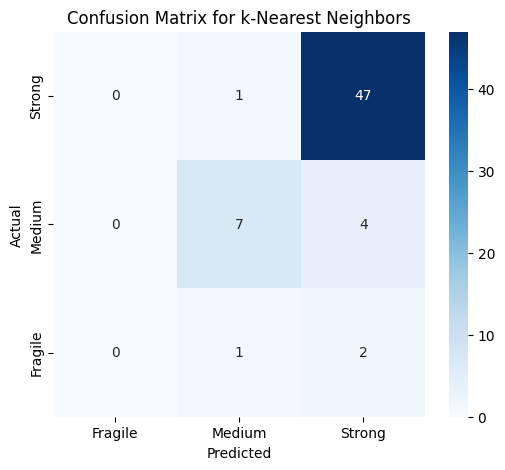


--- Random Forest Classifier ---
Accuracy: 0.9032
Classification Report:
              precision    recall  f1-score   support

     Fragile       0.00      0.00      0.00         3
      Medium       0.89      0.73      0.80        11
      Strong       0.91      1.00      0.95        48

    accuracy                           0.90        62
   macro avg       0.60      0.58      0.58        62
weighted avg       0.86      0.90      0.88        62



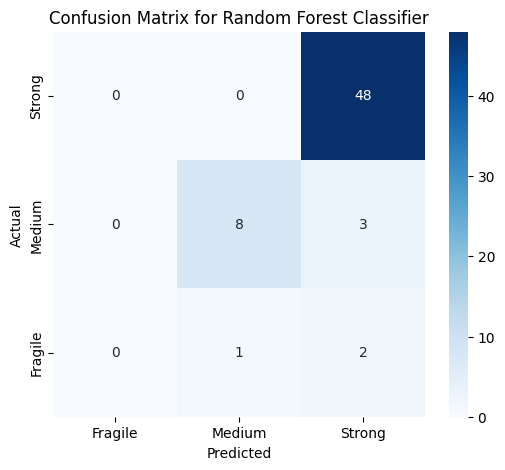


--- Logistic Regression ---
Accuracy: 0.9032
Classification Report:
              precision    recall  f1-score   support

     Fragile       1.00      1.00      1.00         3
      Medium       0.69      0.82      0.75        11
      Strong       0.96      0.92      0.94        48

    accuracy                           0.90        62
   macro avg       0.88      0.91      0.90        62
weighted avg       0.91      0.90      0.91        62



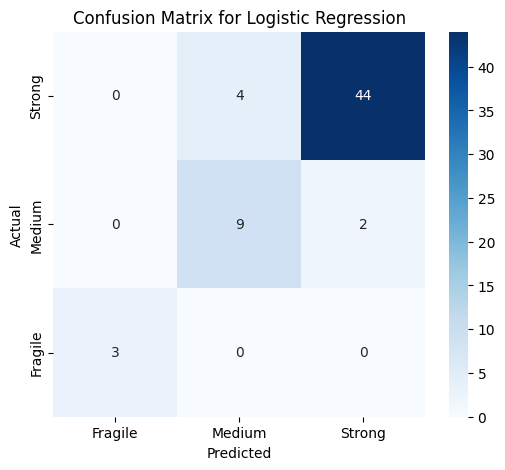


--- k-Nearest Neighbors ---
Accuracy: 0.8710

--- Random Forest Classifier ---
Accuracy: 0.9032

--- Logistic Regression ---
Accuracy: 0.9032

Best classifier saved for elongation!


In [13]:
#Remove all columns that have an unknown strength rating
data = data[data['strength_rating'] != 'Unknown']


X = data[['fe', 'c', 'mn', 'si', 'cr', 'ni', 'mo', 'v', 'n', 'nb', 'co', 'w', 'al', 'ti']]
y = data['strength_rating']


#Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
) #We have to stratify the data so that the distribution of the target variable is 
  #the same in both the training and testing sets e.g., there's only a few fragile samples

#Initialize classifiers
models = {
    "k-Nearest Neighbors": KNeighborsClassifier(),
    "Random Forest Classifier": RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE, class_weight="balanced"),
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight="balanced")
}

#Train and evaluate models
for model_name, model in models.items():
    print(f"\n--- {model_name} ---")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test) 
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}")
    
    # Classification report
    print("Classification Report:")
    print(classification_report(y_test, y_pred, zero_division=0))
    
    # Confusion Matrix
    unique_labels = sorted(set(y_test))
    cm = confusion_matrix(y_test, y_pred, labels=unique_labels)
    cm_reversed = cm[::-1]

    # Plot Confusion Matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_reversed, annot=True, fmt="d", cmap="Blues",
                xticklabels=unique_labels, yticklabels=unique_labels[::-1])  # Reverse only y-tick labels
    plt.title(f"Confusion Matrix for {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.savefig(f"confusion_matrix_{model_name}.png")
    plt.show()
    
# Train and Save Best Classifier
best_classifier = None
best_accuracy = float("-inf")

for model_name, model in models.items():
    print(f"\n--- {model_name} ---")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Evaluate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}")
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_classifier = model

# Save the best classifier to a file
joblib.dump(best_classifier, "elongation_classifier.pkl")
print("\nBest classifier saved for elongation!")

Finally, with our algorithms trained, we were able to apply them to a randomly generated data set of potential steels and select the strongest steels, with the least amount of Co and Ni in their compositions

Number of candidates before filtering: 1000
Number of candidates after filtering: 62
Optimized Candidates:
            fe         c        mn        si         cr        ni        mo  \
767  64.780790  0.751054  7.091272  4.503639  10.063744  0.051691  2.499729   
954  69.609213  0.897731  5.613248  0.675496  13.172693  0.075415  2.746423   
783  72.137105  0.978563  2.797082  4.168891   3.641773  0.134954  4.238012   
46   80.021192  0.766131  1.044991  4.848519   1.097017  0.251078  1.410473   
68   70.698020  0.242250  1.231022  3.997451   6.424101  0.253219  6.082451   
505  69.270477  1.717537  4.974370  2.751204   8.007758  0.420578  0.956560   
376  65.621293  0.647956  8.169695  2.561925   9.871158  0.509642  1.835071   
235  70.586200  1.287321  3.066774  3.829352   4.932403  0.567651  2.709338   
190  74.329820  0.926084  1.335825  2.111537  10.129847  0.575666  1.810917   
277  67.793674  1.047343  6.523986  2.697062   7.633362  0.624074  4.949990   

            v         n

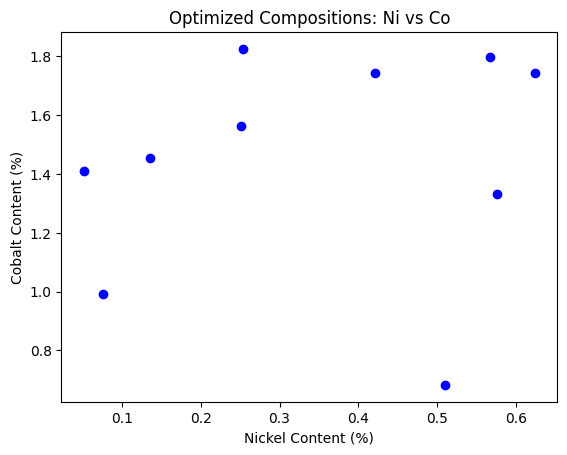

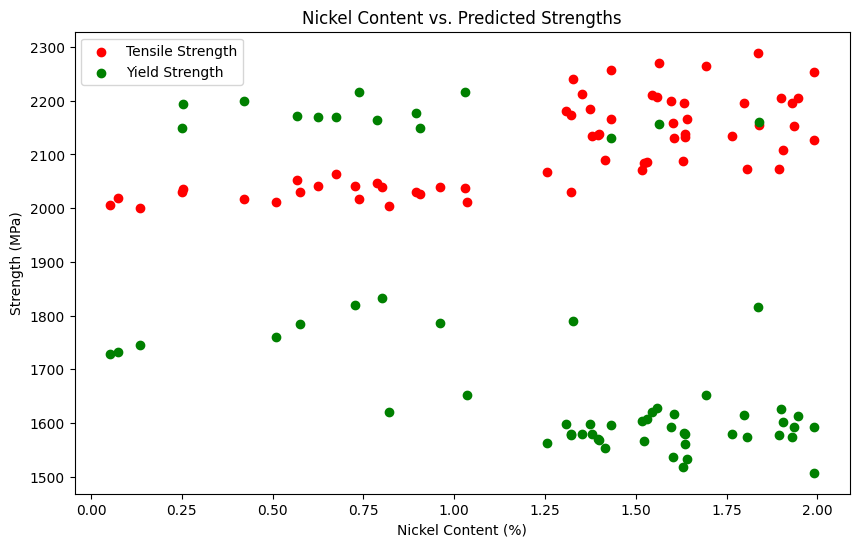

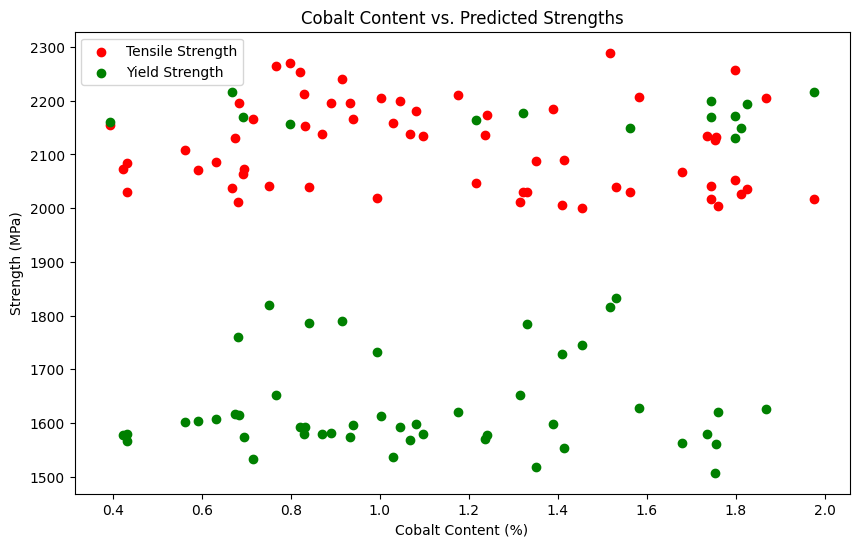

In [18]:
# Load pre-trained models
tensile_regressor = joblib.load("tensile_strength_regressor.pkl")
yield_regressor = joblib.load("yield_strength_regressor.pkl")
elongation_classifier = joblib.load("elongation_classifier.pkl")

# Define the bounds for each element (in weight %)
bounds = {
    "fe": (50, 95),  # Iron (essential in steel)
    "c": (0, 2),     # Carbon 
    "mn": (0, 10),   # Manganese
    "ni": (0, 5),    # Nickel (minimize)
    "co": (0, 2),    # Cobalt (minimize)
    "cr": (0, 15),   # Chromium
    "mo": (0, 5),    # Molybdenum
    "v": (0, 2),     # Vanadium
    "n": (0, 0.5),   # Nitrogen
    "nb": (0, 2),    # Niobium
    "w": (0, 5),     # Tungsten
    "al": (0, 2),    # Aluminum
    "ti": (0, 2),    # Titanium
    "si": (0, 5),    # Silicon 
}

def generate_compositions(bounds : dict, n_samples : int) -> pd.DataFrame:
    compositions = []
    for _ in range(n_samples):
        comp = {element: random.uniform(*bounds[element]) for element in bounds}
        # Scale to ensure the sum is 100%
        total = sum(comp.values())
        for element in comp:
            comp[element] = comp[element] / total * 100
        compositions.append(comp)
    return pd.DataFrame(compositions)

candidates = generate_compositions(bounds, n_samples=1000)

# Reorder columns so that they're the same as the excel file
feature_order = ['fe', 'c', 'mn', 'si', 'cr', 'ni', 'mo', 'v', 'n', 'nb', 'co', 'w', 'al', 'ti']
candidates = candidates[feature_order]

# Predict outputs
candidates["tensile_strength"] = tensile_regressor.predict(candidates[feature_order])
candidates["yield_strength"] = yield_regressor.predict(candidates[feature_order])
candidates["elongation_class"] = elongation_classifier.predict(candidates[feature_order])

print("Number of candidates before filtering:", len(candidates))

# Filter valid candidates
filtered_candidates = candidates[
    (candidates["tensile_strength"] >= 2000) &
    (candidates["yield_strength"] >= 1500) &
    (candidates["elongation_class"].isin(["Medium", "Strong"])) & 
    (candidates["ni"] <= 2) &
    (candidates["co"] <= 2)
]
print("Number of candidates after filtering:", len(filtered_candidates))

# Select and display the top candidates
optimized_candidates = filtered_candidates.sort_values(["ni", "co"]).head(10)
print("Optimized Candidates:")
print(optimized_candidates)

# Plot Ni vs. Co for optimized candidates
plt.scatter(optimized_candidates["ni"], optimized_candidates["co"], c="blue")
plt.xlabel("Nickel Content (%)")
plt.ylabel("Cobalt Content (%)")
plt.title("Optimized Compositions: Ni vs Co")
plt.show()

# Plot 1: Nickel (Ni) vs. Strengths
plt.figure(figsize=(10, 6))
plt.scatter(filtered_candidates["ni"], filtered_candidates["tensile_strength"], color="red", label="Tensile Strength")
plt.scatter(filtered_candidates["ni"], filtered_candidates["yield_strength"], color="green", label="Yield Strength")
plt.xlabel("Nickel Content (%)")
plt.ylabel("Strength (MPa)")
plt.title("Nickel Content vs. Predicted Strengths")
plt.legend()
plt.show()

# Plot 2: Cobalt (Co) vs. Strengths
plt.figure(figsize=(10, 6))
plt.scatter(filtered_candidates["co"], filtered_candidates["tensile_strength"], color="red", label="Tensile Strength")
plt.scatter(filtered_candidates["co"], filtered_candidates["yield_strength"], color="green", label="Yield Strength")
plt.xlabel("Cobalt Content (%)")
plt.ylabel("Strength (MPa)")
plt.title("Cobalt Content vs. Predicted Strengths")
plt.legend()
plt.show()
